In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import spacy
import os
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
bag_size = 2000
bio_file_prefix = 'bio'
bio_field = 'user description'

In [ ]:
csvname=bio_file_prefix+".csv" #changed
# csvname=file_prefix+".csv" #changed
bio_data_orig=pd.read_csv(csvname)
bio_data=bio_data_orig.copy()
bio_data.drop(bio_data.columns[bio_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(bio_data)

In [ ]:
def filter_text(in_data, field):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[field][i]=newtext
  return data

In [ ]:
filtered_bio_data=filter_text(bio_data, bio_field)
filtered_bio_data

,user description,class
0,"[mother, of, 4, ex, wife, of, 3, battling, hea...",0
1,"[wchs, tv, serves, the, charleston, huntington...",0
2,"[patient, engagement, revenue, cycle, manageme...",0
3,"[home, of, the, minnesota, and, always, live, ...",0
4,"[spectrum, news, 1, offers, the, best, 24, hou...",0
...,...,...
5782,[none],1
5783,[none],1
5784,"[hermit, who, loves, to, read, and, has, 4, do...",1
5785,"[a, well, educated, mind, will, always, have, ...",1


In [ ]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[bio_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[bio_field][i]=newtext
  return data

In [ ]:
portered_stemmed_data=porterstemming(filtered_bio_data)
portered_stemmed_data

,user description,class
0,mother 4 ex wife 3 battl health inequ misinfor...,0
1,wch tv serv charleston huntington market lates...,0
2,patient engag revenu cycl manag healthcar thou...,0
3,home minnesota alway live free app,0
4,spectrum news 1 offer best 24 hour local news ...,0
...,...,...
5782,none,1
5783,none,1
5784,hermit love read 4 dog like peopl,1
5785,well educ mind alway question answer helen keller,1


In [ ]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[bio_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[bio_field][i]=newtext
  return data

In [ ]:
lemmatization_data=lemmatization(filtered_bio_data)
lemmatization_data

,user description,class
0,mother of 4 ex wife of 3 battling health inequ...,0
1,wchs tv serves the charleston huntington marke...,0
2,patient engagement revenue cycle management he...,0
3,home of the minnesota and always live on the f...,0
4,spectrum news 1 offers the best 24 hour local ...,0
...,...,...
5782,none,1
5783,none,1
5784,hermit who loves to read and has 4 dogs that i...,1
5785,a well educated mind will always have more que...,1


In [ ]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[bio_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [ ]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

In [ ]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = bag_size)
  X = cv.fit_transform(corpus).toarray()
  return X

In [ ]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=bag_size) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [ ]:
X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

In [ ]:
df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
df_portered_CV

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
df_lemmatization_CV

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_portered_TF_IDF=tf_idf_vec(portered_corpus)
X_lemmatization_TF_IDF=tf_idf_vec(lemmatization_corpus)

In [ ]:
df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
df_portered_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
df_lemmatization_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.192655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.181248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered_CV.to_csv('processed_dataset/'+bio_file_prefix+'_portered_CV_independent.csv',index=False) 
df_lemmatization_CV.to_csv('processed_dataset/'+bio_file_prefix+'_lemmatization_CV_independent.csv',index=False)

In [ ]:
df_portered_TF_IDF.to_csv('processed_dataset/'+bio_file_prefix+'_portered_TF_IDF_independent.csv',index=False) 
df_lemmatization_TF_IDF.to_csv('processed_dataset/'+bio_file_prefix+'_lemmatization_TF_IDF_independent.csv',index=False)

In [ ]:
## PCA starts

In [ ]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  #plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components-1])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [ ]:
# PCA on lemmatization data
y = df_lemmatization_TF_IDF['class']
X_lemmatization_tf = df_lemmatization_TF_IDF.copy()
X_lemmatization_tf.drop ('class', axis=1, inplace=True)

X_lemmatization_cv = df_lemmatization_CV.copy()
X_lemmatization_cv.drop ('class', axis=1, inplace=True)

0.05
Variance explained by all 2000 principal components = 100.00000000000017
[  5.92272504   8.78806735  11.26547316 ... 100.         100.
 100.        ]

97.33478679212588
1200



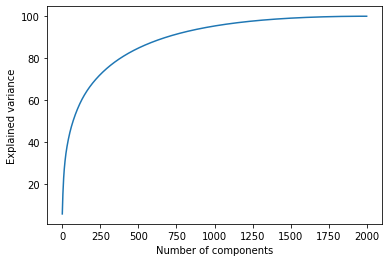

In [ ]:
# PCA lemmatization CV
total_components = len(X_lemmatization_cv.columns)
print (100/total_components)
total_components
# X_lemmatization_cv
n_components = 1200
X_lemmatization_cv_PCA = perform_PCA (X_lemmatization_cv, y, total_components, n_components)

0.05
Variance explained by all 2000 principal components = 100.00000000000013
[ 12.16151952  13.32646954  14.31087426 ... 100.         100.
 100.        ]

96.12063935479435
1300



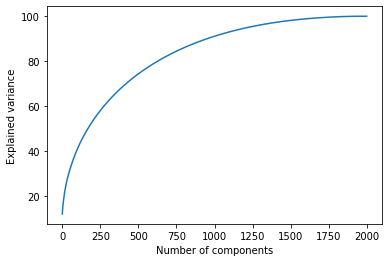

In [ ]:
# PCA lemmatization TF IDF
total_components = len(X_lemmatization_tf.columns)
print (100/total_components)
n_components = 1300
X_lemmatization_tf_PCA = perform_PCA (X_lemmatization_tf, y, total_components, n_components)

In [ ]:
# def split_data_train_test_split(X,y):
#  from sklearn.model_selection import train_test_split
#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#  return(X_train, X_test,y_train,y_test)

import math
from sklearn.model_selection import train_test_split

def split_data_train_test_split(X,y):
    X_class = {
        0: [],
        1: []}
    for i in range(len(y)):
        X_class[y[i]].append(X[i])
    X_0_candidate = X_class[0][:len(X_class[1])]
    X_0_add = X_class[0][len(X_class[1]):]
    
    X_candidate = np.concatenate((X_0_candidate, X_class[1]))
    
    y_candidate = np.array([0 for i in range(len(X_0_candidate))])
    y_candidate = np.concatenate((y_candidate,np.array([1 for i in range(len(X_0_candidate))])))

    y_0_add = np.array([0 for i in range(len(X_0_add))])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_candidate, y_candidate, test_size = 0.2, random_state = 0)

#     X_test = np.concatenate((X_test, X_0_add))
#     y_test = np.concatenate((y_test, y_0_add))
    
    return(X_train, X_test,y_train,y_test)

In [ ]:

X_train_lemmatization_cv, X_test_lemmatization_cv,y_train_lemmatization_cv,y_test_lemmatization_cv=split_data_train_test_split(X_lemmatization_cv_PCA,y)
X_train_lemmatization_tf, X_test_lemmatization_tf,y_train_lemmatization_tf,y_test_lemmatization_tf=split_data_train_test_split(X_lemmatization_tf_PCA,y)

In [ ]:
y_test_lemmatization_cv

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,

In [ ]:
# y

In [ ]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

0.05
Variance explained by all 2000 principal components = 100.00000000000014
[  3.41076638   6.08183924   8.40273798 ... 100.         100.
 100.        ]

96.94938186767178
1250



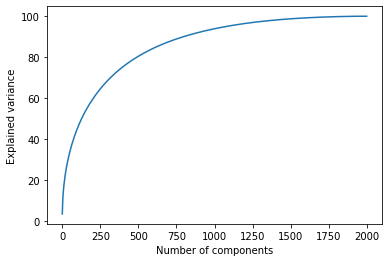

In [ ]:
# PCA portered CV
total_components = len(X_portered_cv.columns)
print (100/total_components)
n_components = 1250
X_portered_cv_PCA = perform_PCA (X_portered_cv, y, total_components, n_components)

0.05
Variance explained by all 2000 principal components = 100.0000000000001
[ 11.98809217  13.10239091  13.95960529 ... 100.         100.
 100.        ]

96.26887506033768
1350



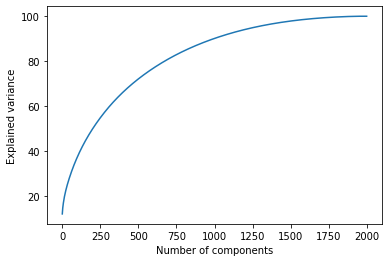

In [ ]:
# PCA portered TF IDF
total_components = len(X_portered_tf.columns)
print (100/total_components)
n_components = 1350
X_portered_tf_PCA = perform_PCA (X_portered_tf, y, total_components, n_components)

In [ ]:
X_train_portered_cv, X_test_portered_cv,y_train_portered_cv,y_test_portered_cv=split_data_train_test_split(X_portered_cv_PCA,y)
X_train_portered_tf, X_test_portered_tf,y_train_portered_tf,y_test_portered_tf=split_data_train_test_split(X_portered_tf_PCA,y)

In [ ]:
y_train_portered_cv

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
y_test_portered_cv

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,

In [ ]:


class Data:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

class Result:
    def __init__(self, y_test, y_pred, label=None):
        self.label = label
        self.accuracy = accuracy_score(y_test,y_pred) * 100
        self.precision = precision_score(y_test, y_pred, average='binary') * 100
        self.recall = recall_score(y_test, y_pred, average='binary') * 100
        self.f1 = f1_score(y_test, y_pred, average='binary') * 100
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        
    def show(self):
        print("Accuracy = ",self.accuracy,"%")
        print("Precision = ",self.precision)
        print("Recall = ",self.recall)
        print("F1 Score = ",self.f1)
        print("Confusion Matrix: \n", self.confusion_matrix)
        
def getResult(data, res):
    result = Result(data.y_test, res)
    result.show()
    return result

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

def getBestModel(data, model, param_grid, cv=10):
    scorer = make_scorer(metrics.f1_score , average='binary')
    grid = GridSearchCV(model, 
                        param_grid,
                        cv=cv,
                        scoring=scorer)


    grid.fit(data.x_train, data.y_train)
    
    return grid

In [ ]:
from sklearn.svm import SVC
from sklearn import svm

def runSVM(data):
    svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                      'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                      'gamma': [1,0.1,0.01,0.001]
                     } 

    grid = getBestModel(data, svm.SVC(), svm_param_grid, cv=2)

    y_pred = grid.predict(data.x_test)
    getResult(data, y_pred)
    print(grid.best_params_)
    return grid

from sklearn.ensemble import RandomForestClassifier

def runRF(data):
    random_forest_params_grid = {
        'n_estimators': [i for i in range(100, 1000, 100)],
        'criterion': [ 'entropy'],
        'max_features': [ 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'random_state': [0]
    }

    grid = getBestModel(data, RandomForestClassifier(), random_forest_params_grid, 2)

    y_pred = grid.predict(data.x_test)
    getResult(data, y_pred)
    print(grid.best_params_)
    return grid
    
from sklearn.tree import DecisionTreeClassifier

def runDT(data):
    decision_tree_params = {
        'criterion': [ 'entropy'],
        'max_depth': [i for i in range(100, 1000, 100)],
        'max_features': [ 'sqrt', 'log2'],
        'random_state': [0]
    }

    grid = getBestModel(data, DecisionTreeClassifier(), decision_tree_params)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred)

    print(grid.best_params_)
    return grid

from sklearn.neighbors import KNeighborsClassifier

def runKNN(data):

    knn_params_grid = {
        'n_neighbors': [i for i in range(3,20)],
        'p': [1,2],
        'metric' : ['euclidean'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }

    grid = getBestModel(data, KNeighborsClassifier(), knn_params_grid)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred)

    print(grid.best_params_)
    return grid

from sklearn.naive_bayes import GaussianNB

def runNB(data):

    nb_params_grid = {
    }

    grid = getBestModel(data, GaussianNB(), nb_params_grid)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred)

    print(grid.best_params_)
    return grid


In [ ]:
data_lemmatization_cv = Data(X_train_lemmatization_cv, y_train_lemmatization_cv, X_test_lemmatization_cv, y_test_lemmatization_cv)
data_lemmatization_tf = Data(X_train_lemmatization_tf, y_train_lemmatization_tf, X_test_lemmatization_tf, y_test_lemmatization_tf)
data_portered_cv = Data(X_train_portered_cv, y_train_portered_cv, X_test_portered_cv, y_test_portered_cv)
data_portered_tf = Data(X_train_portered_tf, y_train_portered_tf, X_test_portered_tf, y_test_portered_tf)


In [ ]:
print('Lemmatization CV')
grid = runSVM(data_lemmatization_cv)

print('Lemmatization TF-IDF')
grid = runSVM(data_lemmatization_tf)

print('Portered CV')
grid = runSVM(data_portered_cv)

print('Portered TF-IDF')
grid = runSVM(data_portered_tf)


Lemmatization CV
Accuracy =  73.83177570093457 %
Precision =  67.37588652482269
Recall =  90.47619047619048
F1 Score =  77.23577235772358
Confusion Matrix: 
 [[126  92]
 [ 20 190]]
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Lemmatization TF-IDF
Accuracy =  77.33644859813083 %
Precision =  70.1067615658363
Recall =  93.80952380952381
F1 Score =  80.24439918533605
Confusion Matrix: 
 [[134  84]
 [ 13 197]]
{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
Portered CV
Accuracy =  76.4018691588785 %
Precision =  69.25795053003534
Recall =  93.33333333333333
F1 Score =  79.5131845841785
Confusion Matrix: 
 [[131  87]
 [ 14 196]]
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Portered TF-IDF
Accuracy =  81.07476635514018 %
Precision =  74.71264367816092
Recall =  92.85714285714286
F1 Score =  82.80254777070064
Confusion Matrix: 
 [[152  66]
 [ 15 195]]
{'C': 0.5, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
print('Lemmatization CV')
grid = runRF(data_lemmatization_cv)

print('Lemmatization TF-IDF')
grid = runRF(data_lemmatization_tf)

print('Portered CV')
grid = runRF(data_portered_cv)

print('Portered TF-IDF')
grid = runRF(data_portered_tf)

Lemmatization CV
Accuracy =  75.23364485981308 %
Precision =  70.47244094488188
Recall =  85.23809523809524
F1 Score =  77.1551724137931
Confusion Matrix: 
 [[143  75]
 [ 31 179]]
{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800, 'random_state': 0}
Lemmatization TF-IDF
Accuracy =  72.66355140186917 %
Precision =  67.28624535315984
Recall =  86.19047619047619
F1 Score =  75.5741127348643
Confusion Matrix: 
 [[130  88]
 [ 29 181]]
{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700, 'random_state': 0}
Portered CV
Accuracy =  76.63551401869158 %
Precision =  70.37037037037037
Recall =  90.47619047619048
F1 Score =  79.16666666666667
Confusion Matrix: 
 [[138  80]
 [ 20 190]]
{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 900, 'random_state': 0}
Portered TF-IDF
Accuracy =  75.23364485981308 %
Pre

In [ ]:
print('Lemmatization CV')
grid = runDT(data_lemmatization_cv)

print('Lemmatization TF-IDF')
grid = runDT(data_lemmatization_tf)

print('Portered CV')
grid = runDT(data_portered_cv)

print('Portered TF-IDF')
grid = runDT(data_portered_tf)


Lemmatization CV
Accuracy =  62.149532710280376 %
Precision =  61.111111111111114
Recall =  62.857142857142854
F1 Score =  61.9718309859155
Confusion Matrix: 
 [[134  84]
 [ 78 132]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'random_state': 0}
Lemmatization TF-IDF
Accuracy =  63.3177570093458 %
Precision =  62.67942583732058
Recall =  62.38095238095238
F1 Score =  62.52983293556086
Confusion Matrix: 
 [[140  78]
 [ 79 131]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'random_state': 0}
Portered CV
Accuracy =  67.7570093457944 %
Precision =  65.78947368421053
Recall =  71.42857142857143
F1 Score =  68.4931506849315
Confusion Matrix: 
 [[140  78]
 [ 60 150]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'random_state': 0}
Portered TF-IDF
Accuracy =  65.18691588785047 %
Precision =  63.20346320346321
Recall =  69.52380952380952
F1 Score =  66.21315192743765
Confusion Matrix: 
 [[133  85]
 [ 64 146]]
{'criterion': 'entrop

In [ ]:
print('Lemmatization CV')
grid = runKNN(data_lemmatization_cv)

print('Lemmatization TF-IDF')
grid = runKNN(data_lemmatization_tf)

print('Portered CV')
grid = runKNN(data_portered_cv)

print('Portered TF-IDF')
grid = runKNN(data_portered_tf)


Lemmatization CV
Accuracy =  67.5233644859813 %
Precision =  61.26984126984127
Recall =  91.9047619047619
F1 Score =  73.52380952380952
Confusion Matrix: 
 [[ 96 122]
 [ 17 193]]
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 15, 'p': 1}
Lemmatization TF-IDF
Accuracy =  57.943925233644855 %
Precision =  53.98936170212766
Recall =  96.66666666666667
F1 Score =  69.28327645051195
Confusion Matrix: 
 [[ 45 173]
 [  7 203]]
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 19, 'p': 1}
Portered CV
Accuracy =  69.85981308411215 %
Precision =  63.54515050167224
Recall =  90.47619047619048
F1 Score =  74.65618860510807
Confusion Matrix: 
 [[109 109]
 [ 20 190]]
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 17, 'p': 1}
Portered TF-IDF
Accuracy =  64.48598130841121 %
Precision =  60.06944444444444
Recall =  82.38095238095238
F1 Score =  69.47791164658635
Confusion Matrix: 
 [[103 115]
 [ 37 173]]
{'algorithm': 'ball_tree', 'metric': 'euclidean'

In [ ]:
print('Lemmatization CV')
grid = runNB(data_lemmatization_cv)

print('Lemmatization TF-IDF')
grid = runNB(data_lemmatization_tf)

print('Portered CV')
grid = runNB(data_portered_cv)

print('Portered TF-IDF')
grid = runNB(data_portered_tf)


Lemmatization CV
Accuracy =  60.046728971962615 %
Precision =  59.06976744186046
Recall =  60.476190476190474
F1 Score =  59.76470588235294
Confusion Matrix: 
 [[130  88]
 [ 83 127]]
{}
Lemmatization TF-IDF
Accuracy =  54.90654205607477 %
Precision =  54.106280193236714
Recall =  53.333333333333336
F1 Score =  53.71702637889687
Confusion Matrix: 
 [[123  95]
 [ 98 112]]
{}
Portered CV
Accuracy =  57.71028037383178 %
Precision =  57.286432160804026
Recall =  54.285714285714285
F1 Score =  55.74572127139364
Confusion Matrix: 
 [[133  85]
 [ 96 114]]
{}
Portered TF-IDF
Accuracy =  55.84112149532711 %
Precision =  54.83870967741935
Recall =  56.666666666666664
F1 Score =  55.73770491803278
Confusion Matrix: 
 [[120  98]
 [ 91 119]]
{}
